<div style="line-height:0.45">
<h1 style="color:#C2F5A6  "> Adaboost trials 3</h1>
</div>
<div style="line-height:1.5">
<div style="margin-top: -15px;">
<h4> Example of a sklearn as base model and metrics calculation. </h4>
</div>
<div style="margin-top: -20px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> @update_class functools notebook + ignore_warnings + grid search + sklearn metrics + %%time magic command + zscore
</span>
</div>
<br>
<div style="margin-top: -15px;">
<div style="line-height:1.2">
<span style="display: inline-block;">
    <h3 style="color: red; display: inline;">Notes:</h3> 
    Input data from "Oimi Robot" project for free games.
</span>
</div>
</div>


In [ ]:
%config Completer.use_jedi = False

In [27]:
import copy
import functools
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.model_selection import KFold, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, recall_score
from sklearn.metrics import classification_report, hamming_loss, log_loss
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix    #ImportError deprecated! 
try:
    from sklearn.utils._testing import ignore_warnings
except ImportError:
    from sklearn.utils.testing import ignore_warnings

from scipy.stats import zscore    

In [2]:
location_all = "./data_csv/ready_table_all.csv"
location_b = "./data_csv/beg_ready.csv"
location_bb = "./data_csv/beg_ready_venerdi.csv"
location_e = "./data_csv/ele_ready.csv"
location_i = "./data_csv/int_ready.csv"
location_a = "./data_csv/adv_ready.csv"
location_pic = "./data_csv/beg_mini.csv"

In [3]:
def update_class(main_class=None, exclude=("__module__", "__name__", "__dict__", "__weakref__")):
    """ Class decorator. Adds all methods and members from the wrapped class to main_class
    
    Args:
        - main_class: class to which to append members. Defaults to the class with the same name as the wrapped class
        - exclude: black-list of members which should not be copied
    """
    def decorates(main_class, exclude, appended_class):
        if main_class is None:
            main_class = globals()[appended_class.__name__]
        for k, v in appended_class.__dict__.items():
            if k not in exclude:
                setattr(main_class, k, v)
        return main_class

    return functools.partial(decorates, main_class, exclude)

In [4]:
class Learning_model_free_games:
    @ignore_warnings(category=ConvergenceWarning)
    def __init__(self, name):
        self.name = name
        self.forest = RandomForestClassifier(random_state = 0, max_features = 10, class_weight = "balanced", 
                                            min_samples_leaf=5, max_depth = 10)
        self.ada = AdaBoostClassifier(base_estimator=self.forest, learning_rate=0.01, n_estimators=500, random_state=0)
        self.my_dataset = pd.read_csv(location_pic, skiprows=None, engine='python')

    @ignore_warnings(category=ConvergenceWarning)
    def prepare_dataset(self):
        #self.my_dataset['a2']= self.my_dataset['a2'].apply(str)
        self.my_dataset = shuffle(self.my_dataset, random_state=3)

    @ignore_warnings(category=FutureWarning)
    def transform_dataset_target_senza_level(self):  
        self.new_dataset = self.my_dataset[['perc_fam','perc_tou','perc_soc','perc_loc','free_game']]
        
        temp_y = self.new_dataset['free_game']
        jobs_e0 = LabelEncoder()
        jobs_e0.fit(temp_y)
        self.yyy = jobs_e0.transform(temp_y)
                
        print("temp_y")
        print()
        print(self.yyy)
        
        jobs_encoder1 = ce.TargetEncoder(return_df=True)
        jobs_encoder2 = ce.TargetEncoder(return_df=True)
        X_column_target_1 = jobs_encoder1.fit_transform(self.my_dataset['S1'], self.yyy)
        X_column_target_2 = jobs_encoder2.fit_transform(self.my_dataset['I1'], self.yyy)

        lg = pd.get_dummies(self.my_dataset['Lowest_grade'], prefix='Lowest_grade', drop_first=True)
        
        column_1 = self.my_dataset.pop('S1')
        column_2 = self.my_dataset.pop('I1')
        column_3 = self.my_dataset.pop('Lowest_grade')
        
        self.my_dataset = pd.concat([lg,self.my_dataset], axis=1)
        self.my_dataset = pd.concat([X_column_target_2,self.my_dataset], axis=1)
        self.my_dataset = pd.concat([X_column_target_1,self.my_dataset], axis=1)
        
        self.my_dataset = shuffle(self.my_dataset, random_state=3)


    @ignore_warnings(category=FutureWarning)
    def split_dataset_3(self):
        train_ratio = 0.80
        validation_ratio = 0.10
        test_ratio = 0.10
        
        self.my_dataset = shuffle(self.my_dataset, random_state=3)
        self.Y = self.my_dataset['free_game']
        self.X = copy.copy(self.my_dataset)
        self.X.pop('free_game')
        
        self.X_train, self.X_test, self.Y_train, self.Y_test = tts(self.X, self.Y, test_size=1 - train_ratio)
        self.X_val, self.X_test, self.Y_val, self.Y_test = tts(self.X_test, self.Y_test, 
                                                            test_size=test_ratio/(test_ratio + validation_ratio)) 

        print(self.X_train, self.X_val, self.X_test)
        
    @ignore_warnings(category=FutureWarning)
    def train_model(self):
        self.ada.fit(self.X_train, self.Y_train)
        

    @ignore_warnings(category=FutureWarning)
    def predict_model(self):
        self.predicted_outputs = self.ada.predict(self.X_val)
        #print(self.predicted_outputs)        

In [5]:
""" @update_class() to place code in different cells but for same class
solution of Grid:
    {'base_estimator__max_depth': 2, 'base_estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 'random_state': 0}
    {'base_estimator__max_depth': 2}
    {'base_estimator__min_samples_leaf': 5}
"""
@update_class()
class Learning_model_free_games:
    def grid(self):
        param_grid = {'base_estimator__max_depth':[i for i in range(2,11,2)],
                    'base_estimator__min_samples_leaf':[5,10],
                    "base_estimator__criterion" : ["gini", "entropy"],
                    'base_estimator__n_estimators': [10, 50, 100, 200, 300, 1000],
                    'base_estimator__bootstrap': [True,False],                      
                    'n_estimators':[10,50,250,500],
                    'learning_rate':[0.01,0.01,1.0],
                    'random_state':[0,1,42]
                    }
        DTC = RandomForestClassifier(random_state = 11, max_features = "auto", class_weight = "balanced", max_depth = None)

        rf = AdaBoostClassifier(base_estimator = DTC)
        
        grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='f1', n_jobs = -1, verbose = 3, cv = 5)
        
        grid_search.fit(self.X_val, self.Y_val)
        print(grid_search.best_params_)

In [6]:
@update_class()
class Learning_model_free_games:
    @ignore_warnings(category=FutureWarning)
    def metric_1(self):
        cr_y1 = classification_report(self.Y_val,self.predicted_outputs)
        print(cr_y1)

    @ignore_warnings(category=FutureWarning)
    def metric_2(self):
        hamm = hamming_loss(self.Y_val,self.predicted_outputs)
        print(hamm)

In [7]:
@update_class()
class Learning_model_free_games:        
    def zzscore(self):
        aa = zscore(self.my_dataset['S1'])
        self.my_dataset['S1'] = aa
        bb = zscore(self.my_dataset['I1'])
        self.my_dataset['I1'] = bb
        
        
        dfdf_1 = self.remove_outlier(self.my_dataset,'S1')

        print("old DATASET")
        print(self.my_dataset)
        print()
        print()
        print()
        print("new DATASET")
        print(dfdf_1)

        dfdf_2 = self.remove_outlier(dfdf_1,'I1')

        print("old DATASET")
        print(self.my_dataset)
        print()
        print()
        print()
        print("new DATASET")
        print(dfdf_2)        
        
        self.my_dataset = dfdf_2
    
        print("new DATASET")
        print(self.my_dataset) 
    
    def remove_outlier(self, df_in, col_name):
        q1 = df_in[col_name].quantile(0.25)
        q3 = df_in[col_name].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
        
        return df_out   

In [8]:
on = Learning_model_free_games(name="train_test#1")
on.prepare_dataset()
on.transform_dataset_target_senza_level()

temp_y

[2 2 1 ... 1 3 0]


In [9]:
on.zzscore()

old DATASET
            S1        I1  Lowest_grade_locomotion  Lowest_grade_socialization  \
1713  1.685483  0.104647                        0                           0   
2271  0.532110  0.104647                        0                           1   
1084 -0.221959 -1.301007                        0                           0   
38    0.092542 -1.301007                        0                           0   
98   -0.440012  0.008140                        0                           0   
...        ...       ...                      ...                         ...   
2219 -0.060595  0.236220                        0                           1   
3423  1.685483  0.236220                        1                           0   
795   1.685483  0.008140                        0                           0   
2464  1.115951 -0.263553                        0                           1   
1507 -1.161420  2.320754                        0                           0   

      Lowest_gr

In [10]:
on.split_dataset_3()

            S1        I1  Lowest_grade_locomotion  Lowest_grade_socialization  \
2845  1.411476  0.104647                        1                           0   
1568 -1.161420  0.357697                        0                           0   
3092 -0.060595 -0.263553                        1                           0   
388  -0.379905  0.396625                        0                           0   
2484  1.115951 -0.535782                        0                           1   
...        ...       ...                      ...                         ...   
1187  1.411476  0.357697                        0                           0   
1204 -0.379905  0.104647                        0                           0   
2669 -0.440012  0.236220                        1                           0   
1743  1.685483  0.008140                        0                           0   
1806  0.092542  0.236220                        0                           1   

      Lowest_grade_touch  p

In [11]:
%%time
on.train_model()

CPU times: user 6min 39s, sys: 2.83 s, total: 6min 41s
Wall time: 6min 51s


In [12]:
%%time
on.predict_model()

CPU times: user 15 s, sys: 64 ms, total: 15.1 s
Wall time: 15.7 s


In [13]:
%%time
on.metric_1()

                precision    recall  f1-score   support

    ApproachMe       0.44      0.45      0.45        42
  AutonomousMe       0.65      0.79      0.72        68
GuessMyFeeling       0.71      0.51      0.59        77
    PutPatches       0.28      0.32      0.30        37
       TouchMe       0.69      0.69      0.69        62

      accuracy                           0.58       286
     macro avg       0.55      0.55      0.55       286
  weighted avg       0.60      0.58      0.58       286

CPU times: user 28.8 ms, sys: 3.97 ms, total: 32.8 ms
Wall time: 35.5 ms


In [14]:
%%time
on.metric_2()

0.4160839160839161
CPU times: user 4.21 ms, sys: 34 µs, total: 4.25 ms
Wall time: 4.8 ms


In [15]:
%%script false --no-raise-error
@update_class()
class Learning_model_free_games:
    
    @ignore_warnings(category=FutureWarning)
    def confusion(self):
        self.muu = multilabel_confusion_matrix(self.Y_test, self.predicted_outputs)
        self.labels = ['ApproachMe', 'PutPatches', 'GuessMyFeeling', 'TouchMe', 'AutonomousMe']
        
    @ignore_warnings(category=FutureWarning)
    def plot_confusion(self,confusion_matrix, axes, class_label, class_names, fontsize=14):      
        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes,  cmap="YlGnBu")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')
        axes.set_title("Confusion Matrix for the class - " + class_label)
    
    @ignore_warnings(category=FutureWarning)
    def confusion_mat(self):
        self.confusion()
        fig, ax = plt.subplots(2, 3, figsize=(12, 7))
        for axes, cfs_matrix, label in zip(ax.flatten(), self.muu, self.labels):
            self.plot_confusion(cfs_matrix, axes, label, ["N", "Y"])            
            
        fig.tight_layout()
        plt.show()

In [16]:
%%script false --no-raise-error
@update_class()
class Learning_model_free_games:
    def confusion_2(self):
        targets = ['ApproachMe', 'PutPatches', 'GuessMyFeeling', 'TouchMe', 'AutonomousMe']
        cm = confusion_matrix(self.Y_val, self.predicted_outputs, labels=targets)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=targets)

        fig, ax = plt.subplots(figsize=(10,10))
        print(cm)
        disp.plot(ax=ax,xticks_rotation=45)
        
        #disp.plot()
        #plt.savefig('/home/notto4/Desktop/books_read.png')
        

In [17]:
%%script false --no-raise-error
on.confusion_mat()

In [18]:
%%script false --no-raise-error
on.confusion_2()

In [19]:
%%script false --no-raise-error
@update_class()
class Learning_model_free_games:        
    def roc(self):
        roc = roc_auc_score(self.Y_test, self.ada.predict_proba(self.X_test), multi_class='ovr')
        print(roc)

In [20]:
#%%script false --no-raise-error
@update_class()
class Learning_model_free_games:
    def calculate_tpr_fpr(self, y_real, y_pred):
        '''
        Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

        Args:
            y_real: The list or series with the real classes
            y_pred: The list or series with the predicted classes

        Returns:
            tpr: The True Positive Rate of the classifier
            fpr: The False Positive Rate of the classifier
        '''
        # Calculates the confusion matrix and recover each element
        cm = confusion_matrix(y_real, y_pred)
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]
        TP = cm[1, 1]

        # Calculates tpr and fpr
        tpr =  TP/(TP + FN) # sensitivity - true positive rate
        fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

        return tpr, fpr
        
    def get_all_roc_coordinates(self, y_real, y_proba):
        '''
        Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.

        Args:
            y_real: The list or series with the real classes.
            y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

        Returns:
            tpr_list: The list of TPRs representing each threshold.
            fpr_list: The list of FPRs representing each threshold.
        '''
        tpr_list = [0]
        fpr_list = [0]
        for i in range(len(y_proba)):
            threshold = y_proba[i]
            y_pred = y_proba >= threshold
            #tpr, fpr = roc_curve(y_real, y_pred)
            tpr, fpr = self.calculate_tpr_fpr(y_real, y_pred)
            #tpr, fpr = self.calculate_tpr_fpr(self.Y_val, self.predicted_outputs)
            #tpr, fpr = self.calculate_tpr_fpr(y_real, y_pred)
            tpr_list.append(tpr)
            fpr_list.append(fpr)
        return tpr_list, fpr_list   

    def plot_roc_curve(self, tpr, fpr, scatter = True, ax = None):
        '''
        Plots the ROC Curve by using the list of coordinates (tpr and fpr).

        Args:
            tpr: The list of TPRs representing each coordinate.
            fpr: The list of FPRs representing each coordinate.
            scatter: When True, the points used on the calculation will be plotted with the line (default = True).
        '''
        if ax == None:
            plt.figure(figsize = (5, 5))
            ax = plt.axes()

        if scatter:
            sns.scatterplot(x = fpr, y = tpr, ax = ax)
        sns.lineplot(x = fpr, y = tpr, ax = ax)
        sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")    
    
    def roc1(self):
        y_proba = self.ada.predict_proba(self.X_val)
        print("y_proba ", y_proba)
        gg = list(y_proba[0])
        print("gg", gg)
        plt.figure(figsize = (12, 8))
        bins = [i/20 for i in range(20)] + [1]
        classes = classes = self.ada.classes_
        print("calalaalala", classes)
        roc_auc_ovr = {}
        for i in range(len(classes)):
            # Gets the class
            c = classes[i]
            

            # Prepares an auxiliar dataframe to help with the plots
            df_aux = self.X_val.copy()
            df_aux['class'] = [1 if y == c else 0 for y in self.Y_val]
            df_aux['prob'] = y_proba[:, i]
            df_aux = df_aux.reset_index(drop = True)

            # Plots the probability distribution for the class and the rest
            ax = plt.subplot(2, 5, i+1)
            sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
            ax.set_title(c)
            #ax.legend([f"Class: {c}", "Rest"])
            ax.set_xlabel(f"P(x = {c})")

            # Calculates the ROC Coordinates and plots the ROC Curves
            ax_bottom = plt.subplot(2, 5, i+6)
            tpr, fpr = self.get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
            self.plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
            ax_bottom.set_title("ROC Curve OvR")

            # Calculates the ROC AUC OvR
            roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
        l1 = plt.legend([f"Class", "Rest"], bbox_to_anchor=(1.04,1), borderaxespad=0)
        plt.tight_layout()
        

y_proba  [[0.43904109 0.12529809 0.08000287 0.2714377  0.08422025]
 [0.08201798 0.45883146 0.33462911 0.12379368 0.00072777]
 [0.11701788 0.32152772 0.11911835 0.04373284 0.39860322]
 ...
 [0.11369465 0.01018084 0.32655551 0.02155122 0.52801778]
 [0.12282794 0.39146236 0.23578683 0.24691172 0.00301115]
 [0.17229018 0.02969392 0.48064369 0.12093612 0.19643608]]
gg [0.43904108856716817, 0.12529809255977767, 0.080002872993904, 0.2714376993048073, 0.08422024657434282]
calalaalala ['ApproachMe' 'AutonomousMe' 'GuessMyFeeling' 'PutPatches' 'TouchMe']


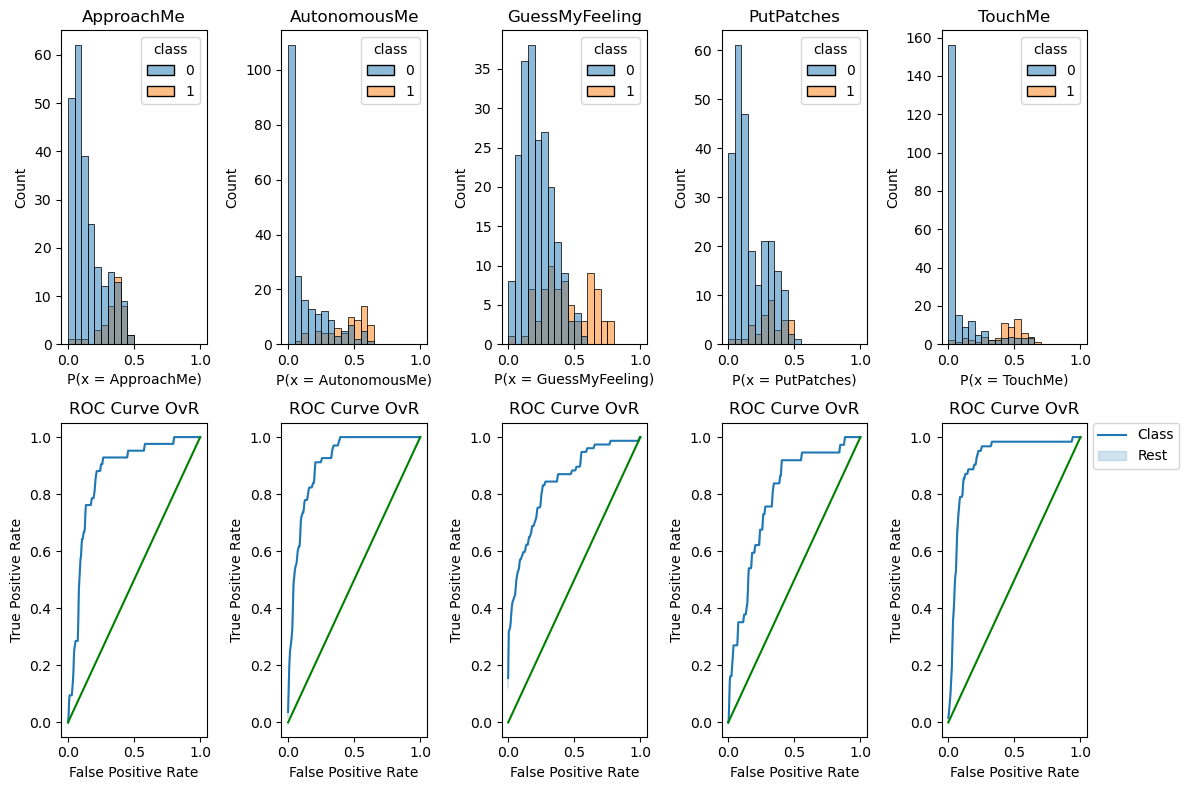

In [21]:
#%%script false --no-raise-error
#%%time
on.roc1()

In [22]:
%%script false --no-raise-error
%%time
on.roc()

In [23]:
%%script false --no-raise-error
@update_class()
class Learning_model_free_games:
    def plot_learning_curve(self,
        estimator,
        title,
        X,
        y,
        axes=None,
        ylim=None,
        cv=None,
        n_jobs=None,
        train_sizes=np.linspace(0.1, 1.0, 5),):
        """
        Generate 3 plots: the test and training learning curve, the training
        samples vs fit times curve, the fit times vs score curve.

        Parameters
        ----------
        estimator : estimator instance
            An estimator instance implementing `fit` and `predict` methods which
            will be cloned for each validation.

        title : str
            Title for the chart.

        X : array-like of shape (n_samples, n_features)
            Training vector, where ``n_samples`` is the number of samples and
            ``n_features`` is the number of features.

        y : array-like of shape (n_samples) or (n_samples, n_features)
            Target relative to ``X`` for classification or regression;
            None for unsupervised learning.

        axes : array-like of shape (3,), default=None
            Axes to use for plotting the curves.

        ylim : tuple of shape (2,), default=None
            Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

        cv : int, cross-validation generator or an iterable, default=None
            Determines the cross-validation splitting strategy.
            Possible inputs for cv are:

              - None, to use the default 5-fold cross-validation,
              - integer, to specify the number of folds.
              - :term:`CV splitter`,
              - An iterable yielding (train, test) splits as arrays of indices.

            For integer/None inputs, if ``y`` is binary or multiclass,
            :class:`StratifiedKFold` used. If the estimator is not a classifier
            or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

            Refer :ref:`User Guide <cross_validation>` for the various
            cross-validators that can be used here.

        n_jobs : int or None, default=None
            Number of jobs to run in parallel.
            ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
            ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
            for more details.

        train_sizes : array-like of shape (n_ticks,)
            Relative or absolute numbers of training examples that will be used to
            generate the learning curve. If the ``dtype`` is float, it is regarded
            as a fraction of the maximum size of the training set (that is
            determined by the selected validation method), i.e. it has to be within
            (0, 1]. Otherwise it is interpreted as absolute sizes of the training
            sets. Note that for classification the number of samples usually have
            to be big enough to contain at least one sample from each class.
            (default: np.linspace(0.1, 1.0, 5))
        """
        if axes is None:
            _, axes = plt.subplots(1, 3, figsize=(20, 5))

        axes[0].set_title(title)
        if ylim is not None:
            axes[0].set_ylim(*ylim)
        axes[0].set_xlabel("Training examples")
        axes[0].set_ylabel("Score")

        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
            estimator,
            X,
            y,
            cv=cv,
            n_jobs=n_jobs,
            train_sizes=train_sizes,
            return_times=True,
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

        # Plot learning curve
        axes[0].grid()
        axes[0].fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )
        axes[0].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )
        axes[0].plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
        axes[0].plot(
            train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
        )
        axes[0].legend(loc="best")

        # Plot n_samples vs fit_times
        axes[1].grid()
        axes[1].plot(train_sizes, fit_times_mean, "o-")
        axes[1].fill_between(
            train_sizes,
            fit_times_mean - fit_times_std,
            fit_times_mean + fit_times_std,
            alpha=0.1,
        )
        axes[1].set_xlabel("Training examples")
        axes[1].set_ylabel("fit_times")
        axes[1].set_title("Scalability of the model")

        # Plot fit_time vs score
        fit_time_argsort = fit_times_mean.argsort()
        fit_time_sorted = fit_times_mean[fit_time_argsort]
        test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
        test_scores_std_sorted = test_scores_std[fit_time_argsort]
        axes[2].grid()
        axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
        axes[2].fill_between(
            fit_time_sorted,
            test_scores_mean_sorted - test_scores_std_sorted,
            test_scores_mean_sorted + test_scores_std_sorted,
            alpha=0.1,
        )
        axes[2].set_xlabel("fit_times")
        axes[2].set_ylabel("Score")
        axes[2].set_title("Performance of the model")

        return plt   
    
    def display_validation_curve(self):
        fig, axes = plt.subplots(3, 2, figsize=(10, 15))

        title = "Learning Curves_1 "
        # Cross validation with 50 iterations to get smoother mean test and train
        # score curves, each time with 20% data randomly selected as a validation set.
        cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

        estimator = self.ada
        self.plot_learning_curve(
            estimator, title, self.X_train, self.Y_train, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
        )
        plt.tight_layout()
        plt.savefig('./validation_curve_beginner_target.png')
        plt.show()

In [24]:
%%script false --no-raise-error
on.display_validation_curve()

In [33]:
@update_class()
class Learning_model_free_games:
    
    @ignore_warnings(category=FutureWarning)
    def kfoldvalid(self):
        k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, test_idx in k_fold.split(self.X):
            self.X_train2, self.X_test2 = self.X[train_idx], self.X[test_idx]
            self.y_train2, self.y_test2 = self.y[train_idx], self.y[test_idx]
        return self.X_train2, self.X_test2, self.y_train2, self.y_test2